# Fashion Mnist - VGG 16

## Import Libraries

In [1]:
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from utils import mnist_reader # Download from Fashion Mnist repo

## Download and Load Data

In [2]:
# Download Data if needed
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [3]:
# Load Data
# Change Data folder respectively
data_folder = "./data"

train_images, train_labels = mnist_reader.load_mnist(data_folder, "train")
test_images, test_labels = mnist_reader.load_mnist(data_folder, "t10k")

train_images = train_images.reshape(-1, 28,28)
test_images = test_images.reshape(-1, 28,28)

## Basic Data Visualization

In [4]:
def visualize_data(data, target, title="Train Data Visualization"):
  labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  # Set the figure size
  fig = plt.figure(figsize=(10,10))
  # Show only the first 50 pictures
  plt.suptitle(title)
  # Inex range
  index_l = random.sample(range(0, len(target)), 30)
  for i in range(25):
      plt.subplot(5,5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(data[index_l[i]], cmap=plt.cm.binary)
      plt.xlabel(labels[target[index_l[i]]])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

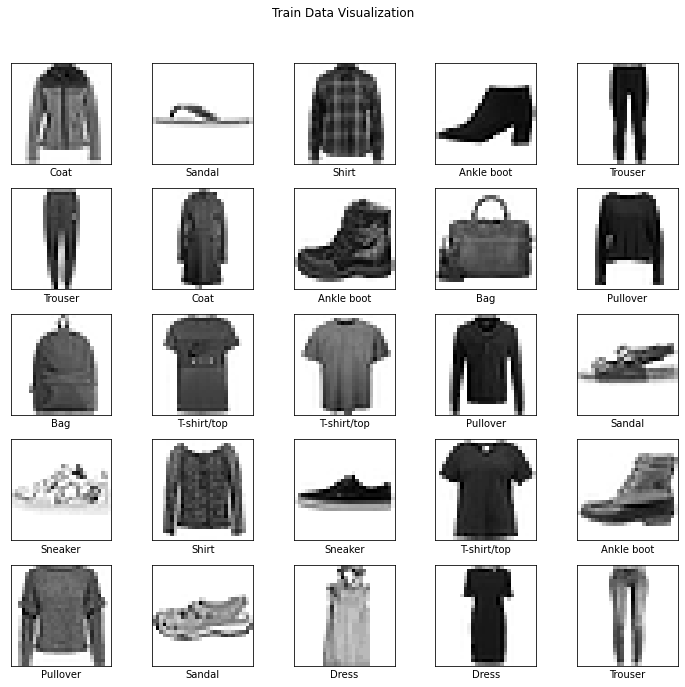

In [5]:
visualize_data(train_images, train_labels)

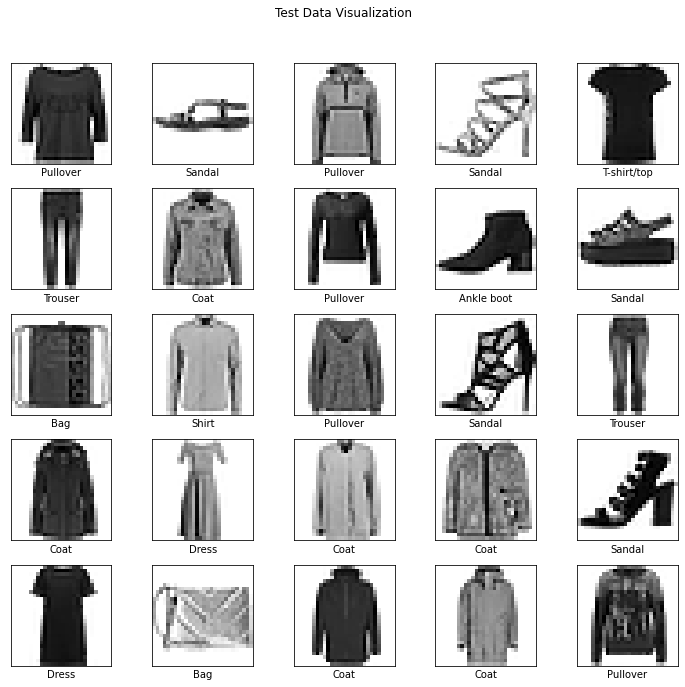

In [6]:
visualize_data(test_images, test_labels, "Test Data Visualization")

## Load VGG 16 Model Trained on ImageNet Data

In [7]:
# Load the pre trained model
# Top is not included for us to customize
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(32,32,3),
    weights='imagenet')

# If u want to freeze
# base_model.trainable = False

## Convert Image to 3 Channel Images (Colored) from a Gray Scale and Resize to 32 x 32

In [8]:
# Convert to 32 x 32
train_images = np.array([np.array(Image.fromarray(im).resize((32,32))) for im in train_images])
test_images = np.array([np.array(Image.fromarray(im).resize((32,32))) for im in test_images])

In [9]:
train_images = np.stack((train_images,)*3, axis=-1)

In [10]:
test_images = np.stack((test_images,)*3, axis=-1)

In [36]:
train_images.shape, test_images.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

## Convert Target Labels to One Hot Encoding 

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
encoder = OneHotEncoder(sparse=False)
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_oh = encoder.transform(test_labels.reshape(-1, 1))

In [39]:
train_labels_oh

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
train_labels_oh.shape

(60000, 10)

## Build Model

In [51]:
def get_model(input_shape=(32, 32, 3)):
  input = tf.keras.layers.Input(shape=input_shape)
  x = base_model(input)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.Dense(32)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

  model = tf.keras.Model(inputs=input, outputs=outputs)
  model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics="acc")
  return model

In [52]:
model = get_model()

In [53]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0   

## Model Training

In [54]:
# Possbile Callbacks
# model check pointer
# early stopping
# learning rate scheduler *optional

# Build Callbacks
MC = tf.keras.callbacks.ModelCheckpoint(
    "models/vgg_16.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5
)

In [55]:
# If kernel crashes or you get an resource exhauseted error, reduce batch size, always use powers of 2 eg: 32, 62, 128...
history = model.fit(train_images, train_labels_oh, epochs=1000, batch_size=256,validation_split=0.1, callbacks=[MC, ES])

Epoch 1/1000
211/211 [==============================] - 22s 102ms/step - loss: 2.3031 - acc: 0.1011 - val_loss: 2.3031 - val_acc: 0.1008
Epoch 2/1000
211/211 [==============================] - 18s 85ms/step - loss: 2.3031 - acc: 0.0989 - val_loss: 2.3031 - val_acc: 0.0973
Epoch 3/1000
211/211 [==============================] - 18s 86ms/step - loss: 2.3030 - acc: 0.1002 - val_loss: 2.3029 - val_acc: 0.1003
Epoch 4/1000
211/211 [==============================] - 18s 86ms/step - loss: 2.3030 - acc: 0.0992 - val_loss: 2.3029 - val_acc: 0.1008
Epoch 5/1000
211/211 [==============================] - 18s 87ms/step - loss: 2.3030 - acc: 0.1004 - val_loss: 2.3029 - val_acc: 0.1008
Epoch 6/1000
211/211 [==============================] - 18s 86ms/step - loss: 2.3029 - acc: 0.1026 - val_loss: 2.3027 - val_acc: 0.0973
Epoch 7/1000
211/211 [==============================] - 18s 85ms/step - loss: 2.3030 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.0942
Epoch 8/1000
211/211 [=========================

## Training Assesment

In [56]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

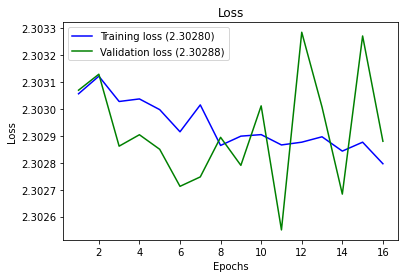

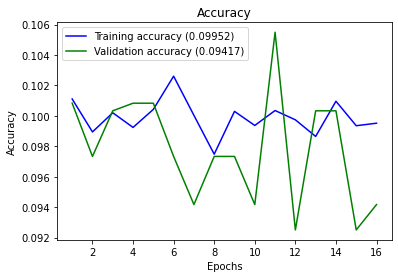

In [57]:
# Plot Loss and Accuracy of Training History
plot_history(history)

## Model Evaluation

In [11]:
# load best model
best_model = tf.keras.models.load_model("./models/vgg_16.h5")

In [59]:
best_model.evaluate(test_images, test_labels_oh)

313/313 [==============================] - 3s 10ms/step - loss: 2.3027 - acc: 0.1000: 0s - loss: 2.3027 - acc: 


[2.3026857376098633, 0.10000000149011612]

In [60]:
predictions = best_model.predict(test_images)
# Get the Single labels from predction instead of an array of probabilities
predictions = np.argmax(predictions, axis=1)

In [61]:
# Accuracy on the Test Set
test_acc = accuracy_score(test_labels, predictions)
print(f"Test Accuracy is {test_acc*100}%")

Test Accuracy is 10.0%


In [62]:
# Classification Report
print(classification_report(test_labels, predictions, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.10      1.00      0.18      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.00      0.00      0.00      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
def plot_confusion_matrix(y_test, y_pred):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Fashion Mnist Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

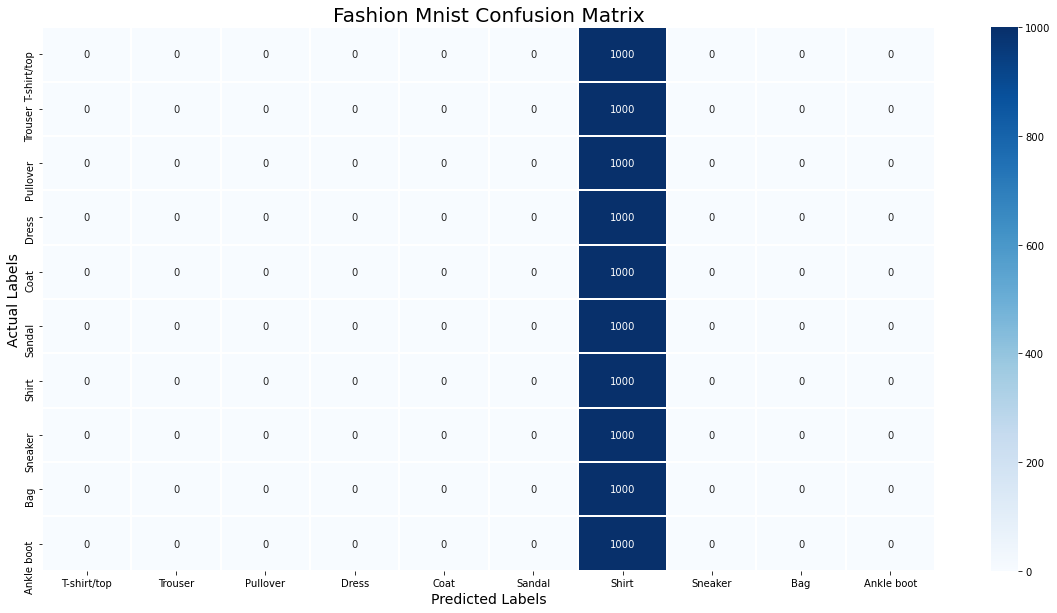

In [64]:
plot_confusion_matrix(test_labels, predictions)

## Summary

- Test Accuracy is 10%
- Model F1 Score is 2%
- Model Precision is 1%
- Model Recall is 10%
- Model is unstable
- Model only accpeted Images with 3 Channels, Image size must be at least 32x32

## VGG 16 from Scratch

In [18]:
def get_model():
    # input

    input = tf.keras.layers.Input(shape =(48,48,3))
    # 1st Conv Block

    x = tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
    x = tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    # 2nd Conv Block

    x = tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    # 3rd Conv block

    x = tf.keras.layers.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    # 4th Conv block

    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 5th Conv block

    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    # Fully connected layers

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics="acc")
    return model

In [19]:
model = get_model()

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                             

## Model Training

In [21]:
# Possbile Callbacks
# model check pointer
# early stopping
# learning rate scheduler *optional

# Build Callbacks
MC = tf.keras.callbacks.ModelCheckpoint(
    "models/vgg_16.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5
)

In [22]:
# If kernel crashes or you get an resource exhauseted error, reduce batch size, always use powers of 2 eg: 32, 62, 128...
history = model.fit(train_images, train_labels_oh, epochs=1000, batch_size=256,validation_split=0.1, callbacks=[MC, ES])

Epoch 1/1000
211/211 [==============================] - 32s 130ms/step - loss: 2.3049 - acc: 0.0996 - val_loss: 2.3028 - val_acc: 0.0985
Epoch 2/1000
211/211 [==============================] - 25s 118ms/step - loss: 2.3030 - acc: 0.1001 - val_loss: 2.3025 - val_acc: 0.1050
Epoch 3/1000
211/211 [==============================] - 25s 117ms/step - loss: 2.3031 - acc: 0.1000 - val_loss: 2.3035 - val_acc: 0.0942
Epoch 4/1000
211/211 [==============================] - 25s 117ms/step - loss: 2.3031 - acc: 0.0984 - val_loss: 2.3027 - val_acc: 0.1032
Epoch 5/1000
211/211 [==============================] - 25s 117ms/step - loss: 2.3030 - acc: 0.0989 - val_loss: 2.3029 - val_acc: 0.1050
Epoch 6/1000
211/211 [==============================] - 25s 119ms/step - loss: 2.3030 - acc: 0.0992 - val_loss: 2.3024 - val_acc: 0.1008
Epoch 7/1000
211/211 [==============================] - 25s 119ms/step - loss: 2.3031 - acc: 0.0987 - val_loss: 2.3030 - val_acc: 0.1008
Epoch 8/1000
211/211 [===================

## Training Assesment

In [23]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

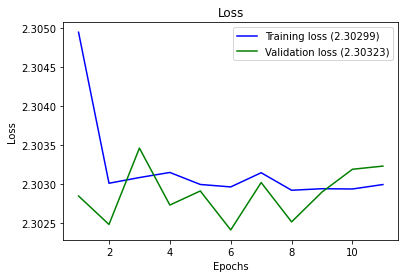

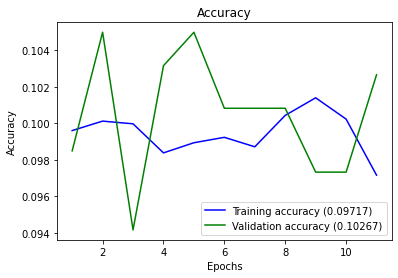

In [24]:
# Plot Loss and Accuracy of Training History
plot_history(history)

## Model Evaluation

In [25]:
# load best model
best_model = tf.keras.models.load_model("./models/vgg_16.h5")

In [26]:
model.evaluate(test_images, test_labels_oh)

313/313 [==============================] - 3s 9ms/step - loss: 2.3028 - acc: 0.1000


[2.302841901779175, 0.10000000149011612]

In [27]:
predictions = model.predict(test_images)
# Get the Single labels from predction instead of an array of probabilities
predictions = np.argmax(predictions, axis=1)

In [28]:
# Accuracy on the Test Set
test_acc = accuracy_score(test_labels, predictions)
print(f"Test Accuracy is {test_acc*100}%")

Test Accuracy is 10.0%


In [29]:
# Classification Report
print(classification_report(test_labels, predictions, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.10      1.00      0.18      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
def plot_confusion_matrix(y_test, y_pred):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Fashion Mnist Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

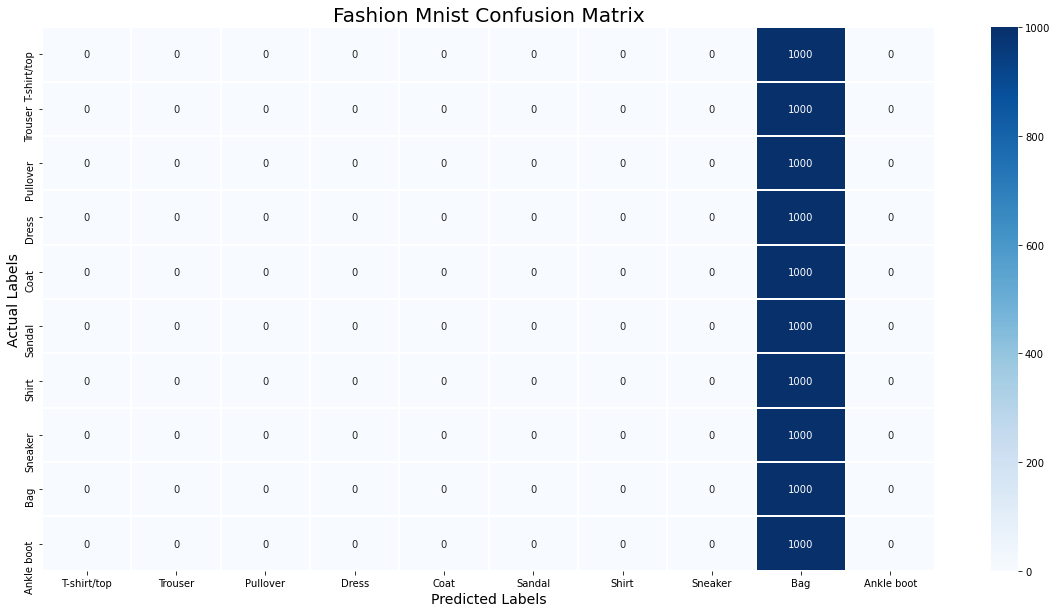

In [31]:
plot_confusion_matrix(test_labels, predictions)

In [ ]:
# same result

In [12]:
from tqdm import tqdm
import time

In [13]:
def get_inference_speed(model, data=test_images[:500]):
    #  GPU warm up
    model.predict(data)
    
    start_time = time.time()
    for i in tqdm(range(100)):
        model.predict(data)
    end_time = time.time()
    speed = (end_time - start_time) / (100 * len(data))
    return speed * 1000

In [14]:
get_inference_speed(best_model)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


0.28126679420471196